In [57]:
import numpy as np
import ot
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [127]:
N_SOURCE = 5000
N_TARGET = 3000

a, b = 5*np.random.random(size=N_SOURCE) , 5*np.random.random(size=N_TARGET) 
a /= a.sum()
b /= b.sum()
c = 0.2*np.random.random(size=(N_SOURCE, N_TARGET))+ 5

In [128]:
eps = 1e-2

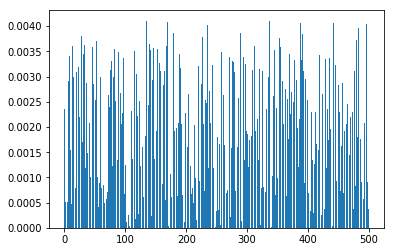

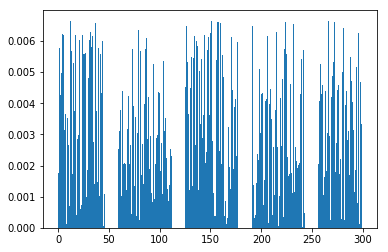

In [81]:
plt.figure()
plt.bar(np.arange(N_SOURCE), a)
plt.show()
plt.figure()
plt.bar(np.arange(N_TARGET), b)
plt.show()

In [104]:
def semi_dual_sag(a, b, c, eps, n_iter):
    L = np.max(a/eps)
    
    n_source = a.shape[0]
    n_target = b.shape[0]
    
    step = 2/(L*n_source)

    vs = []
    
    v = np.zeros(n_target)
    d = np.zeros(n_target)
    g = np.zeros((n_source, n_target))
    
    for _ in range(n_iter):
        i = random.randrange(n_source)
        d -= g[i, :]
        
        tmp = b * np.exp((1/eps)*(v - c[i, :]))
        grad = b - tmp/tmp.sum()
        
        g[i, :] = a[i]*grad

        d += g[i, :]
        v += step*d

        vs.append(v)

    
    u = -eps*np.log(np.sum(np.exp((v - c)/eps) * b, axis=1))
    pi = (np.exp((u[:, np.newaxis] + v[np.newaxis, :] - c)/eps)* 
                  a[:, np.newaxis] * b[np.newaxis, :])
    
    return pi

In [105]:
np.abs(((a.T @ pi) - b)).max()

0.006632490384396624

In [129]:
pi = semi_dual_sag(a, b, c, eps, 100000)

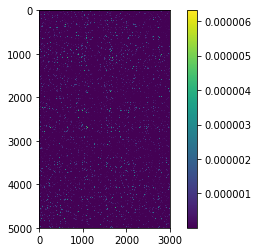

In [130]:
plt.imshow(pi)
plt.colorbar()

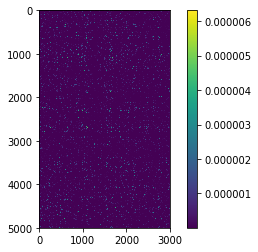

In [131]:
plt.imshow(ot.sinkhorn(a, b, c, eps))
plt.colorbar()

In [86]:
np.sqrt(np.sum((ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag') - ot.sinkhorn(a, b, c, eps))**2))

0.0017734905637624583

/Users/hugo/anaconda3/lib/python3.7/site-packages/ot/stochastic.py:83: RuntimeWarning: invalid value encountered in true_divide
  khi = exp_beta / (np.sum(exp_beta))
/Users/hugo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


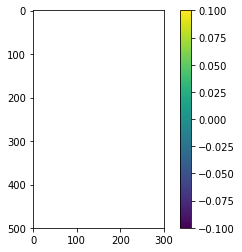

In [126]:
plt.imshow(ot.stochastic.solve_semi_dual_entropic(a, b, c, 1e-4, 'sag'))
plt.colorbar()

In [91]:
%%timeit
l = ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag', numItermax=1000)

103 ms ± 49.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
%%timeit
l2 =semi_dual_sag(a, b, c, eps, 1000)

50.9 ms ± 7.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%%prun
l = ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag', numItermax=100000)

         704515 function calls in 7.027 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.633    2.633    6.989    6.989 stochastic.py:87(sag_entropic_transport)
   100000    2.474    0.000    3.739    0.000 stochastic.py:13(coordinate_grad_semi_dual)
   101000    0.656    0.000    0.656    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.613    0.000    0.613    0.000 {method 'randint' of 'mtrand.RandomState' objects}
   101000    0.303    0.000    1.012    0.000 fromnumeric.py:64(_wrapreduction)
   100500    0.211    0.000    1.268    0.000 fromnumeric.py:1821(sum)
   101000    0.052    0.000    0.052    0.000 {method 'items' of 'dict' objects}
   100500    0.048    0.000    0.048    0.000 {built-in method builtins.isinstance}
        1    0.022    0.022    7.026    7.026 stochastic.py:331(solve_semi_dual_entropic)
        1    0.009    0.009    0.015    0.015 stochastic.py:258(c_transform_entr

In [81]:
%%prun
l2 =semi_dual_sag(a, b, c, eps, 100000)

         802441 function calls in 7.147 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.529    5.529    7.147    7.147 <ipython-input-80-e207436f3c31>:1(semi_dual_sag)
   100002    0.808    0.000    0.808    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.192    0.000    0.269    0.000 random.py:224(_randbelow)
   100000    0.180    0.000    1.122    0.000 {method 'sum' of 'numpy.ndarray' objects}
   100000    0.166    0.000    0.435    0.000 random.py:174(randrange)
   100000    0.133    0.000    0.942    0.000 _methods.py:34(_sum)
   100000    0.059    0.000    0.059    0.000 {method 'append' of 'list' objects}
   102425    0.057    0.000    0.057    0.000 {method 'getrandbits' of '_random.Random' objects}
   100000    0.020    0.000    0.020    0.000 {method 'bit_length' of 'int' objects}
        3    0.002    0.001    0.002    0.001 {built-in method numpy.core.multiarray.zeros}
        1  

In [70]:
import random

In [72]:
%timeit np.random.randint(1000)

4.12 µs ± 723 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [74]:
%timeit random.randint(0, 1000 - 1)

3.51 µs ± 807 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [75]:
%timeit random.randrange(1000)

2.31 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
